# Feature Extraction

## Power Sensor
In this section we will calculate power spectral density at sensor level across all frequency bands. We will use the [Welch's method](https://mne.tools/stable/generated/mne.time_frequency.psd_array_welch.html) to estimate the power spectral density (PSD) of each EEG channel. The PSD is estimated on each experimental for each participant.

In [ ]:
import pickle
import re
from pathlib import Path

import mne
import numpy as np
import pandas as pd
from mne.time_frequency import psd_array_welch

############### Constants ###############
# define brain patches and frequency boundries
## channels name
epochs = mne.read_epochs('data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif', verbose=0)
ch_names = epochs.ch_names.copy()  # make sure to copy the list because it is mutable in place
[ch_names.remove(i) for i in ['M1', 'M2', 'EOG1', 'EOG2', 'ECG']]
all_channels = epochs.ch_names

# name of electrode groups
ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5'],
 'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
 'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
 'LO': ['O1', 'PO3'],
 'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6',],
 'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
 'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
 'RO': ['O2', 'PO4'],
 'FZ': ['Fpz', 'Fz'],
 'CZ': ['Cz', 'FCz'],
 'PZ': ['Pz', 'CPz'],
 'OZ': ['POz', 'Oz', 'Iz'],
 'all': ch_names
}

# index of electrode groups
ba_patches_ind = {}
for k,v in ba_patches.items():
    temp = [all_channels.index(i) for i in v]
    ba_patches_ind[k] = temp

# frequency indces
freq = dict(delta=(0, 24),
            theta=(24, 56),
            alpha=(56, 96),
            beta=(96, 233),
            gamma=(233, 330))

############ Helper Functions ############
def calculate_psd(epochs,
                  eeg_dir='data/clean_data/',
                  save_path='data/psds_dict.pkl',
                  save=False):
    psds_dict = {}
    for path in sorted(Path(eeg_dir).glob('*.fif')):
        subject, task = re.search('sub-(.*)_ses-01_task-(.*)_proc-clean_epo.*', path.stem).groups()
        print('>>>>>> get psds for subject: ', subject, ' task: ', task, ' <<<<<<')
        epochs = mne.read_epochs(path)
        data = np.hstack(epochs.get_data())
        psds,freqs = psd_array_welch(data,
                                sfreq=1000,
                                fmin=1,
                                fmax=42,
                                n_fft=8000,
                                verbose=0
                                )
        psds_dict[subject+'_'+task] = psds

    psds_dict['freqs'] = freqs
    if save:
        with open(save_path, 'wb') as handle:
            pickle.dump(psds_dict, handle)
    return psds_dict
    
def aggregate_psds(psds_dict, ba_patches_ind, freq):
    """Aggregate PSDs across channels and frequency bands."""
    # create a dataframe from aggreagated data, power in picovolts
    psds_agg = {}
    for k1, v1 in psds_dict.items():
        for k2, v2 in ba_patches_ind.items():
            for k3, v3 in freq.items():
                psds_agg[k1+'-'+k2+'_'+k3] = v1[v2].mean(0)[v3[0]:v3[1]].mean(0) * 10000 ** 3 #microvolts^2
    return psds_agg

def create_classification_df(psds_agg,
                             bh_path='data/behavioral_data/archived/behavioral_data.csv',
                             save_path='data/classification_datasets/power_sensor_3rd.csv',
                             save=False):
    df = pd.DataFrame(psds_agg.items(), columns=['index', 'values']).set_index('index')
    df[['session', 'power']] = df.index.to_series().apply(lambda x:x.split('-')).apply(pd.Series)
    df.reset_index(drop=True, inplace=True)
    df = df.pivot(index='session', columns='power', values='values')

    # merge behavioral data with power data
    # open behavioral data
    bh = pd.read_csv(bh_path)
    bh = bh.iloc[:208]

    # merge with power data
    df[['bids_id', 'condition']] = df.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
    df['session'] = df['condition'].apply(lambda x:x[-1])
    df.reset_index(drop=True, inplace=True)
    # change session and bids_id type at once to be the same type as the behavioral data
    df = df.astype({'session': 'int64'})
    df = pd.merge(bh, df, how='right', on=['session', 'bids_id'], right_index=False)
    df.insert(1, 'condition', df.pop('condition'))
    df = df.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)

    if save:
        df.to_csv(save_path)
    return df

In [2]:
# load/calculate PSDs
psds_path = 'docs/psds_dict_15092023.pkl'
if Path(psds_path).exists():
    with open(psds_path, 'rb') as handle:
        psds_dict = pickle.load(handle)

    # save frequencies in a different object
    freqs = psds_dict['freqs']
    psds_dict.pop('freqs')

else:
    print('>>>>>> There is no PSDs in the current directory, creating a PSDs dictionary...')
    psds_dict = calculate_psd(epochs, save=False)
    freqs = psds_dict['freqs']
    psds_dict.pop('freqs')

# aggregate PSDs
psds_agg = aggregate_psds(psds_dict, ba_patches_ind, freq)

# create classification dataset
df = create_classification_df(psds_agg, save=False)

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_68667/2039701411.py:88: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df[['session', 'power']] = df.index.to_series().apply(lambda x:x.split('-')).apply(pd.Series)
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_68667/2039701411.py:98: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df[['bids_id', 'condition']] = df.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)


### relative powers
Here we quantify the relative power in each frequency band by dividing the absolute power by the power in basline and sham conditions.

#### relative to baseline

In [54]:
## baseline corrected PSDs
X = df.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session'])

def normalize_psd(df):
    df.set_index('condition', inplace=True)
    baseline = df.loc['baseline1'].apply(lambda x: 10 * np.log10(x/(10000 ** 3)))
    df = df.apply(lambda x: 10 * np.log10(x/(10000 ** 3)) - baseline, axis=1)
    return df
   
X = X.groupby('bids_id').apply(normalize_psd)
X = X.reset_index()
cols = X.columns.delete([0,1])
cols = [i + '-decibel' for i in cols]
cols = ['bids_id', 'condition'] + cols
X.columns = cols

relative_power = pd.merge(df, X, how='right', on=['bids_id', 'condition'], right_index=False)
# relative_power.to_csv('data/classification_datasets/relative_power_sensor_3rd.csv', index=False)

#### relative to control condition

In [ ]:
df_ = df.query('condition.str.contains("experience")')
df_['is_it_real'] = df_['procedure'].apply(lambda x: 'sham' if x == 'whitenoise' or x == 'embedded' else 'real')

In [27]:
## power relative to control condition
df_ = df_.query('description == "hypnosis"')
session_data = ['hypnosis_depth', 'procedure', 'description', 'session', 'condition']
X = df_.drop(columns=session_data)
session_df = df_[session_data + ['bids_id', 'is_it_real']]

def normalize_psd(df):
    df.set_index('is_it_real', inplace=True)
    control = df.loc['sham'].apply(lambda x: 10 * np.log10(x/(10000 ** 3)))
    df = df.apply(lambda x: 10 * np.log10(x/(10000 ** 3)) - control, axis=1)
    return df
    
X = X.groupby('bids_id').apply(normalize_psd)
X.drop('bids_id', axis=1, inplace=True)  # where does this bids_id come from???
X = X.reset_index()
psds_relative_to_sham = pd.merge(session_df, X, how='right', on=['bids_id', 'is_it_real'], right_index=False)
psds_relative_to_sham = psds_relative_to_sham.query('is_it_real == "real"').drop(columns=['is_it_real']).reset_index(drop=True)
# psds_relative_to_sham.to_csv('data/classification_datasets/power_sensor_relative_to_sham.csv')

In [69]:
## normalized PSDs by cotrol conditions labeled as 'sham'
df_ = df_.drop(df_.query('is_it_real == "real" and description == "control"').index)
session_data = ['condition', 'is_it_real', 'hypnosis_depth', 'procedure', 'session']
session_df = df_[session_data].drop(columns='is_it_real').reset_index(drop=True)
X = df_.drop(columns=session_data)

def normalize(df):
    df.set_index('description', inplace=True)
    control = df.loc['control'].apply(lambda x: 10 * np.log10(x/(10000 ** 3)))
    df = df.apply(lambda x: 10 * np.log10(x/(10000 ** 3)) - control, axis=1)
    return df

X = X.groupby('bids_id').apply(normalize)
X = X.reset_index()
# join session info with power data
psds_relative_to_control = pd.concat([session_df, X], axis=1)
psds_relative_to_control = psds_relative_to_control.query('description != "control"')
# psds_relative_to_control.to_csv('data/classification_datasets/power_sensor_relative_to_sham.csv')

In [19]:
## power of the real hypnosis condition (described as 'hypnosis') normalized by the control condition
## labeled as 'control'
df_['hypnosis_or_control'] = df_.apply(lambda x:'hypnosis' if x['is_it_real'] == 'real' and
                                        x['description'] == 'hypnosis' else 'control' if
                                        x['is_it_real'] == 'sham' and x['description'] == 'control' else
                                        None, axis=1)
df_ = df_.dropna().reset_index(drop=True)

session_data = ['condition', 'is_it_real', 'hypnosis_depth', 'procedure', 'description', 'session']
session_df = df_[session_data].drop(columns='is_it_real').reset_index(drop=True)
X = df_.drop(columns=session_data)

def normalize(df):
    df.set_index('hypnosis_or_control', inplace=True)
    control = df.loc['control'].apply(lambda x: 10 * np.log10(x/(10000 ** 3)))
    df = df.apply(lambda x: 10 * np.log10(x/(10000 ** 3)) - control, axis=1)
    return df

X = X.groupby('bids_id').apply(normalize)
X = X.reset_index()
# join session info with power data
psds_relative_to_control = pd.concat([session_df, X], axis=1)
psds_relative_to_control = psds_relative_to_control.query('description != "control"')
# psds_relative_to_control.to_csv('data/classification_datasets/power_sensor_real_relative_to_sham.csv')

## Power source

In [ ]:
# imports
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne.time_frequency import psd_array_welch
from IPython.display import clear_output

In [ ]:
#### constant variables to be used in the code ####

# sampling rate
sfreq = 512

# frequency bands of interest
frequencies = {'delta': (1, 3.875),
               'theta': (4, 7.875),
               'alpha': (8, 12.875),
               'beta': (13, 30),
               'lowgamma': (30.125, 42) 
}
# bands = Bands(frequencies)

# labels for the psd table based on Yeo2011 7 networks
yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemisferes = ['lh', 'rh']

labels_ = [yeo7[k] + '_' + hemisferes[i] 
           for k in yeo7.keys() 
           for i in range(len(hemisferes))]

#### helper function to be used in the code ####

# get dataframe of powers for each frequency band
def get_power_bands_df(psds, freqs, labels=labels_):
    
    # initiate a dictionary to store power from each band
    psds_bands = {}
    
    # average the power over each band
    for k in frequencies.keys():
        temp = psds[:, np.where((frequencies[k][0] <= freqs) & (freqs <= frequencies[k][1]) == True)[0]]
        psds_bands[k] = temp.mean(1)
    
    # create and return a dataframe with the power from each band across all networks
    df = pd.DataFrame.from_dict(psds_bands, orient='index', columns=labels).T.stack().reset_index()
    df['new_col'] = df['level_0'] + '_' + df['level_1']
    df.drop(['level_0', 'level_1'], axis=1, inplace=True)
    
    return df.set_index('new_col').T

In [ ]:
#### extract PSD features on parcellated source data ####

# initialize a dataframe to store PSD features for all subjects
psd_df = pd.DataFrame()

# open the parcellated source data
for subject_path in sorted(Path('data/parcellated_source_yeo7').glob('*.npz')):
  
  subject, task = re.search('(.*)_task-(.*)_labels.*', subject_path.stem).groups()
  
  if task.__contains__('experience'):

    label_ts = np.load(subject_path)['labels']
  
    # create a continuous data array from the parcellated source data
    label_continious = np.hstack(np.array(label_ts))

    # calculate psd on continuous data
    psds, freqs = psd_array_welch(label_continious,
                                  sfreq=sfreq,
                                  fmin=1,
                                  fmax=42,
                                  n_fft=4096, # window size is 4096/512 = 8s
                                  n_overlap=2048, # 50% overlap
                                  n_jobs=1)

    # extract periodic parameters
    df_periodic = get_power_bands_df(psds, freqs=freqs)
    
    # reindex the dataframe
    index = subject[4:] + '_' + task
    df_periodic.index = [index]
    
    # append to the main dataframe
    psd_df = pd.concat([psd_df, df_periodic], axis=0)
  
    clear_output()

In [ ]:
# create a classification dataframe
bh = pd.read_csv('data/behavioral_data/behavioral_data.csv')
bh = bh.iloc[:208]

# open power data
psd_df[['bids_id', 'condition']] = psd_df.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
psd_df['session'] = psd_df['condition'].apply(lambda x:x[-1]) 
psd_df.reset_index(drop=True, inplace=True)
psd_df['session'] = psd_df['session'].astype('int64')
psd_df = pd.merge(bh, psd_df, how='right', on=['session', 'bids_id'], right_index=False)
psd_df = psd_df.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
psd_df.insert(1, 'condition', psd_df.pop('condition'))
psd_df.head()

# psd_df.to_csv('data/classification_datasets/power_source_2nd.csv', index=0)

In [ ]:
# classification
# imports
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold, cross_val_score, cross_validate)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import SVC, LinearSVC

# load grid results from 
grid_results = pd.read_csv('data/classification_results/grid_results.csv')  
grid_results = grid_results.query('param_extract__kind == "power source"') # only power source grid results
grid_results['label'] = grid_results['param_extract__frequency_band'] + ' ' + grid_results['param_extract__kind']
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx].reset_index()
params = grid_results[['label', 'mean_test_score', 'std_test_score', 'param_select', 'param_clf__C']]

In [ ]:
power = pd.read_csv('data/classification_datasets/power_source_2nd.csv', index_col=0)

# remove subject 52
power = power.iloc[:204]

# get only hypnosis conditions
power = power.query('description == "hypnosis"')

# output feature
y = power['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)

# input features
col_name = [i for i in power.columns if 'gamma' in i]
X = power[col_name]

# transform data
# X = X.apply(lambda x:x*(100)**12) #yoctovolt

# CV and groups
CV = GroupShuffleSplit(n_splits=200, test_size=0.2)
groups = power['bids_id']

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', SelectFromModel(estimator=SVC(kernel='linear'))),
    ('clf', LinearSVC(max_iter=1000000, C=0.1, dual=True, class_weight='balanced')),
])

scores = cross_val_score(pipe, X, y, groups=groups, scoring='accuracy', cv=CV, n_jobs=-1)
scores.mean(), scores.std()

(0.5713872855405464, 0.11247318434830475)

In [ ]:
params

label  mean_test_score  std_test_score  \
0  delta power source         0.472424        0.103795   
1  theta power source         0.496234        0.103916   
2  alpha power source         0.528788        0.102435   
3   beta power source         0.526028        0.104040   
4  gamma power source         0.545747        0.109029   

                                      param_select  param_clf__C  
0                                      passthrough           0.1  
1                                      passthrough           0.1  
2                                      passthrough           0.1  
3  SelectFromModel(estimator=SVC(kernel='linear'))           1.0  
4  SelectFromModel(estimator=SVC(kernel='linear'))           5.0

Accuracy in this new dataset is not different than the previous analysis.
Accuracy of the non-logarithmic transformed data is higher and closer to the random (0.57).

# Correlation Sensor

In [ ]:
import pickle
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from mne_connectivity import envelope_correlation
from IPython.display import clear_output

In [3]:
frequencies = {'delta': (1, 3.875),
               'theta': (4, 7.875),
               'alpha': (8, 12.875),
               'beta': (13, 30),
               'lowgamma': (30.125, 42)}

frequencies = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'lowgamma': (30, 42)  
}

# Envelope Correlation
def get_connectivity(epochs,
                     frequencies: dict,
                     sfreq: float = 1000,
):
    # drop unwanted channels
    epochs.drop_channels(ch_names=['M1', 'M2', 'EOG1', 'EOG2', 'ECG'])
    
    def bp_gen(epochs, fmin, fmax, sfreq):
        for epoch in epochs:
            yield mne.filter.filter_data(epoch, sfreq=sfreq, l_freq=fmin, h_freq=fmax)
    
    # each segment in epochs is 1 second
    # To compute the connectivity, we want segments that its lenght is about 30 seconds (or a bit less)
    raw = np.array([np.hstack(epochs.get_data())])
    epochs = np.array_split(raw, 10, axis=1)
    
    conns = {} 
    for bp in frequencies.keys():
        conn_obj = envelope_correlation(bp_gen(epochs, frequencies[bp][0], frequencies[bp][1], sfreq),
                                               orthogonalize='pairwise')
        conn = conn_obj.combine()
        conn = conn.get_data(output='dense')[..., 0]
        conns[bp] = conn
        
    return conns

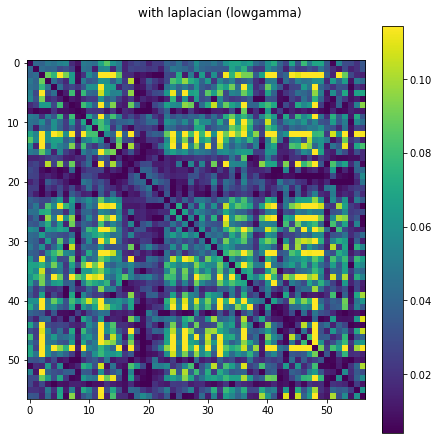

In [ ]:
def plot_corr(corr, title):
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
        shw = ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
        fig.suptitle(title)
        plt.colorbar(shw)

key = 'lowgamma'
plot_corr(conns[key], f'with laplacian ({key})')

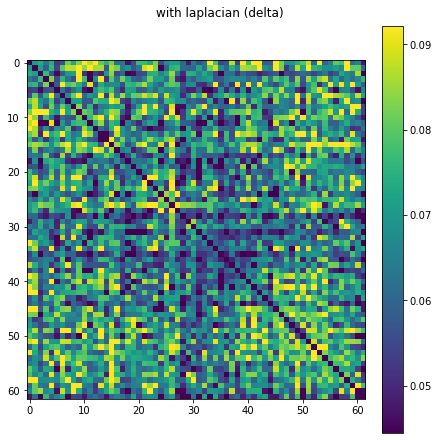

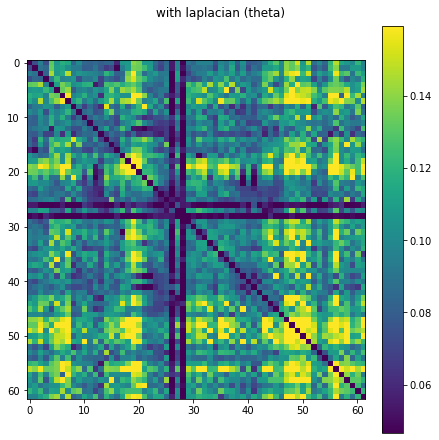

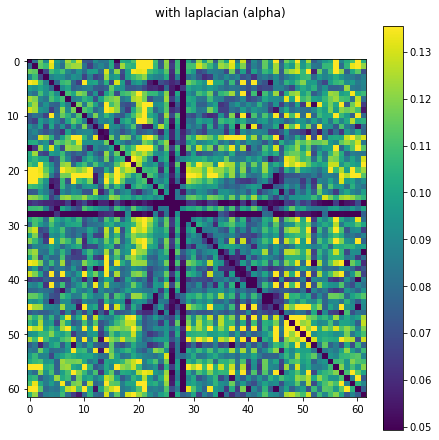

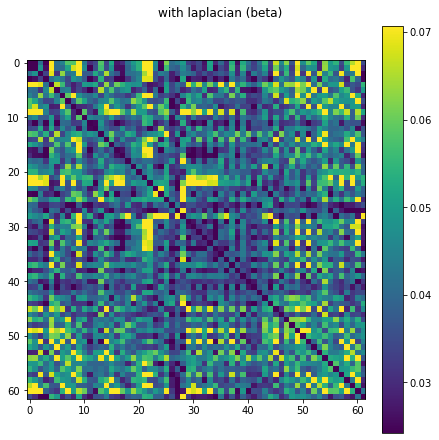

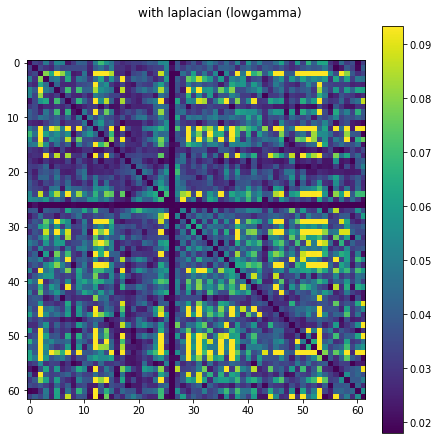

In [ ]:
def plot_corr(corr, title):
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
        shw = ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
        fig.suptitle(title)
        plt.colorbar(shw)

for key in frequencies.keys():
    plot_corr(conn_with_laplacian[key], f'with laplacian ({key})')
#     plot_corr(conn[key], f'with laplacian ({key})')

In [ ]:
for subject_path in sorted(Path('data/clean_data').glob('*.fif')):
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo', subject_path.name).groups()
    
    connectivity_path = f'data/connectivities/correlation_sensor/{subject}_task-{task}_conn-corr_sensor_filtered.pkl'
    if Path(connectivity_path).exists():
        continue
    
    print('>>>>>>>>', subject, task)
    if task == 'baseline2' or 'induction' in task:
        continue

    # open epochs
    epochs = mne.read_epochs(subject_path, preload=True)
    
    # set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)
      
    # surface laplacian
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    
    # compute connectivity
    conn = get_connectivity(epochs_csd, frequencies)

    # save connectivity
    with open(connectivity_path, 'wb') as f:
        pickle.dump(conn, f)
        
    clear_output()